# Chest X-Ray Lung segmentation

In [16]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
from cv2 import imread, createCLAHE 
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow import case, cast, greater, argmax
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import  Input, Dense, Reshape, Add, Cropping2D, Dropout, Conv2D, Conv2DTranspose, Activation, BatchNormalization, ZeroPadding2D, Concatenate, MaxPooling2D

In [2]:
# switching the run-time to the GPU for faster execution
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

# Set GPU memory limitation
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 10GB of memory on the GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [
            tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

In [3]:
image_path = os.path.join("Lung Segmentation/CXR_png/")
mask_path = os.path.join("Lung Segmentation/masks/")
images = os.listdir(image_path)
mask = os.listdir(mask_path)

mask = [fName.split(".png")[0] for fName in mask] # name of the mask or segment 
image_file_name = [fName.split("_mask")[0] for fName in mask] # name of the image file 

In [4]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


In [5]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

In [6]:
# define the function to get data 

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [7]:
#perform sanity check

def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [29]:
# Load training and testing data
dim = 256
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:43<00:00,  3.19it/s]


# Perform Sanity Check

It is prudent to perform sanity check of the data correspondance. It become a routine check-up after a while but it is very crucial to check if we had made a mistake in loading the data.

training set


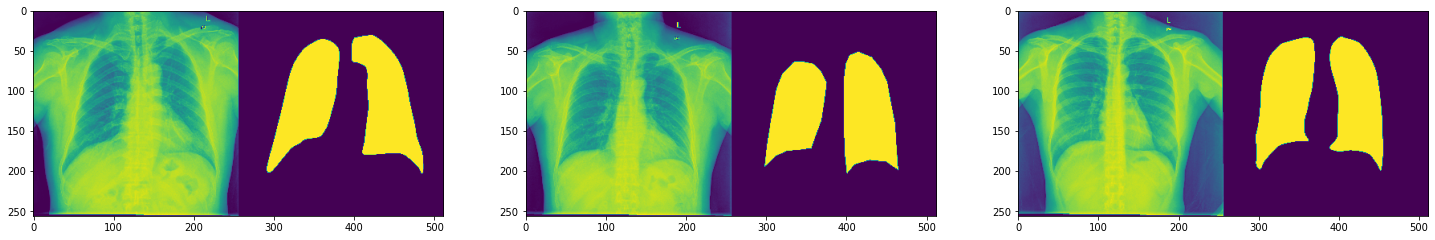

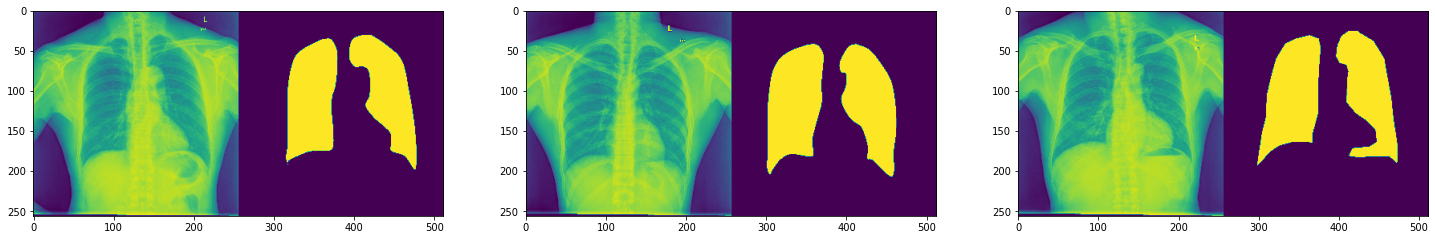

testing set


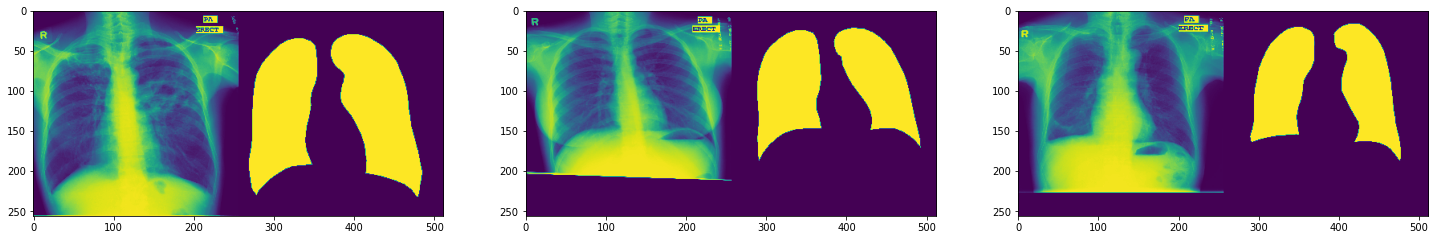

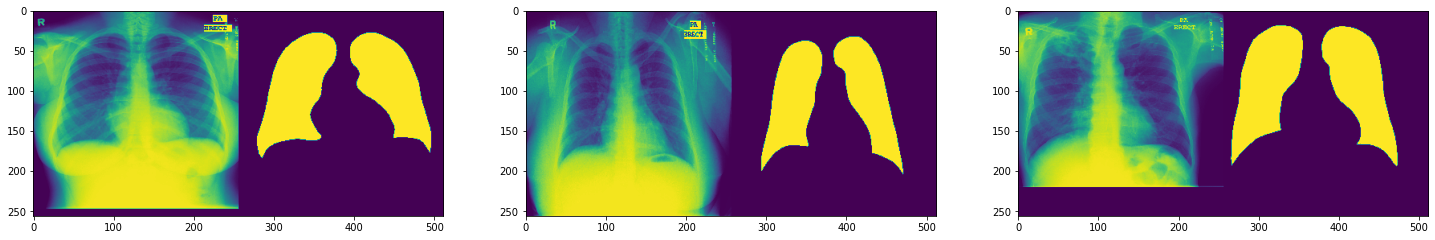

In [30]:
print("training set")
plotMask(X_train,y_train)
print("testing set")
plotMask(X_test,y_test)

Both the sets looks correct. Let's combine them and further use them as a unified dataset.

In [48]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

In [49]:
images.shape

(704, 256, 256, 1)

## Define  the network and callbacks

I am going to use my favourite segmentation network - U-Nets. You can read about them [here](https://arxiv.org/abs/1505.04597).

In [50]:
def UNET(image_width, image_height,num_classes):
    
    inputs = Input((image_width, image_height, 1))
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = keras.layers.concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = keras.layers.concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = keras.layers.concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = keras.layers.concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=[inputs], outputs=[conv10])
    
    return model

#### Compile and train the Unet Model

In [51]:
model = UNET(256, 256, 1)
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 256, 256, 32) 320         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_95[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_96[0][0]                  
______________________________________________________________________________________

## Callbacks, Early Stopping and Reduced LR


In [52]:
# weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(mode='min', filepath='Model_Weights.h5', monitor='loss',
                     save_weights_only='True', verbose=1)
reduceLearningRate=ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, verbose=1 ,mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=True)
callbacks_list = [checkpoint, reduceLearningRate, early_stopping]

In [53]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy',
                  metrics=['accuracy'])


#### Train the model

In [56]:
from IPython.display import clear_output
from sklearn.model_selection import train_test_split


train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2018)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 16,
                  epochs = 10,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)

model.save('my_model.h5') 
#clear_output()

Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.4949 - accuracy: 0.7456WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0040s vs `on_test_batch_end` time: 0.0698s). Check your callbacks.

Epoch 00001: saving model to Model_Weights.h5
36/36 [==============================] - 10s 274ms/step - loss: 0.4949 - accuracy: 0.7456 - val_loss: 0.4389 - val_accuracy: 0.7596
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.3783 - accuracy: 0.7456
Epoch 00002: saving model to Model_Weights.h5
36/36 [==============================] - 10s 273ms/step - loss: 0.3783 - accuracy: 0.7456 - val_loss: 0.3329 - val_accuracy: 0.7596
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.3270 - accuracy: 0.7457
Epoch 00003: saving model to Model_Weights.h5
36/36 [==============================] - 10s 274ms/step - loss: 0.3270 - accuracy: 0.7457 - val_loss: 0.3407 - val_accuracy: 0.7614
Epoch 4/10


## Plot the metric and evaluate 

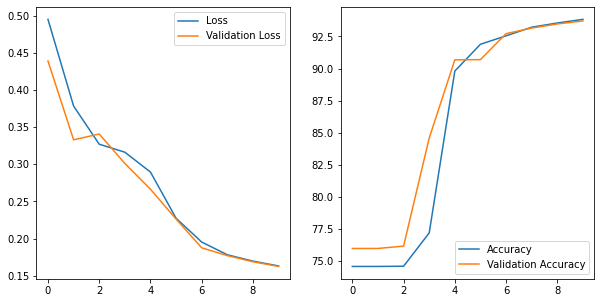

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

## Test the model

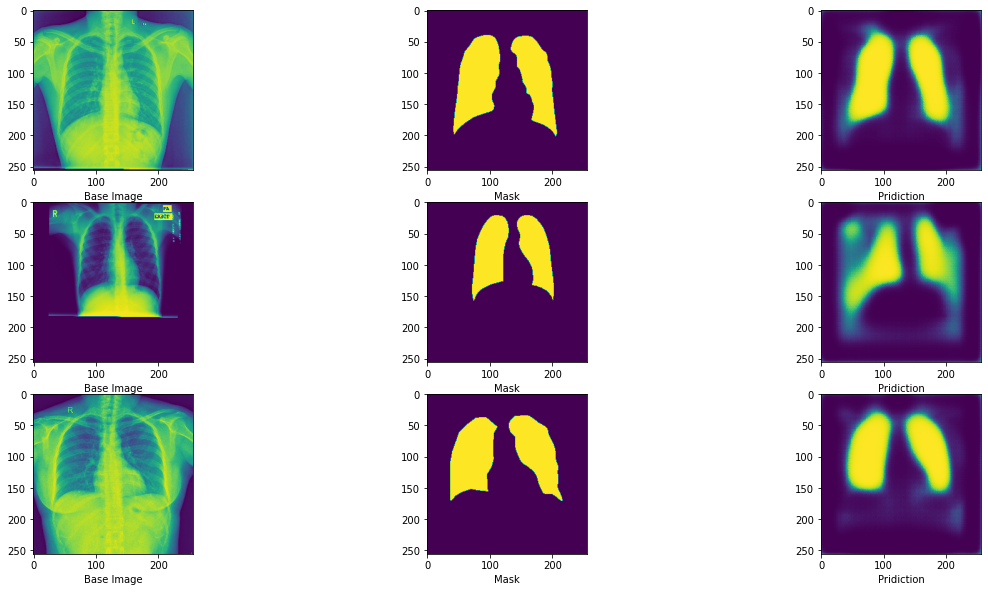

In [66]:
pred_candidates = np.random.randint(1,test_vol.shape[0],10)
preds = model.predict(test_vol)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(test_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(test_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Pridiction")

In [ ]:
import ipywidgets as widgets
from IPython.display import display

UNet_model = UNET(256,256,1)
UNet_model.load_weights('Model_Weights.h5')
def prediction(model=UNet_model):
    # Uploade image from computer
    uploaded = FileUpload(accept = 'image/*')
    display(uploaded)
    #Get image name
    imgName=list(uploaded)[0]
    # read image, resize and resize it 
    img=cv2.imread(imgName)
    img=cv2.resize(img,(256,256))[:,:,0]
    norm=np.reshape(img,(1, 256, 256, 1))
    #Feed it to the model
    pred=UNet_model.predict(norm)
    print('\n')
    plt.imshow(np.squeez(pred))
    print('\n')